In [10]:
%pylab inline
import scipy
from scipy.interpolate import*

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['polyint', 'insert', 'griddata']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
#look at scipy documentation

In [11]:
#Runge function
def myfun(x):
    return 1/(1+50*(x-.5)**2)

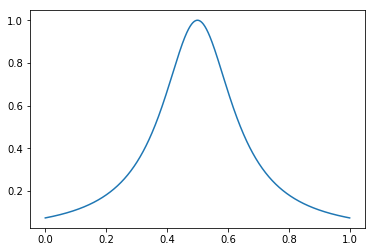

In [12]:
N = 1025 #points to displace my function
M = 10 #points to construct interpolation

x = linspace(0,1,N)
q = linspace(0,1,M)

plot(x,myfun(x))

In [14]:
#Piecewise linear interpolation with scipy, least squares, L2 projection

In [16]:
#1.Piecewise linear interpolation:

In [17]:
interp1d??

Init signature: interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
Source:        
class interp1d(_Interpolator1D):
    """
    Interpolate a 1-D function.

    `x` and `y` are arrays of values used to approximate some function f:
    ``y = f(x)``.  This class returns a function whose call method uses
    interpolation to find the value of new points.

    Note that calling `interp1d` with NaNs present in input values results in
    undefined behaviour.

    Parameters
    ----------
    x : (N,) array_like
        A 1-D array of real values.
    y : (...,N,...) array_like
        A N-D array of real values. The length of `y` along the interpolation
        axis must be equal to the length of `x`.
    kind : str or int, optional
        Specifies the kind of interpolation as a string
        ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
        'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
  

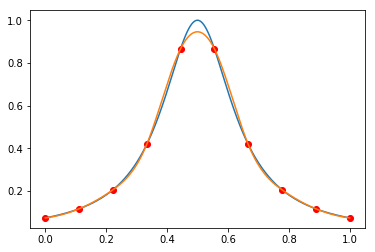

In [33]:
yq = myfun(q)
p = interp1d(q,yq)
p = interp1d(q,yq, kind = 'quadratic') #it will also make sure that 1st derivative from left and right are fine (is using splines interpolation)
p = interp1d(q,yq, kind = 'cubic') #it will also make sure that 1st and 2nd derivative from left and right are fine (using splines interpolation)

plot(x,myfun(x))
plot(q,yq,'ro')
plot(x,p(x)) #interp1d defines a callable (like as if I defined a function)

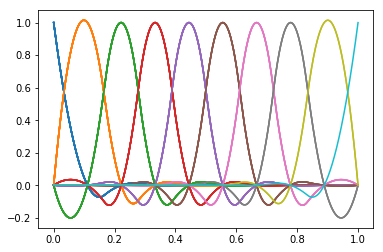

In [64]:
#I want piecewise linear functions that are 0 except that the point q_i where they have value 1
#Possible basis function:

#i = 0

B = zeros((N,M))
dB = zeros((N,M))


for i in range(M):
    c = zeros((M,))  #coefficients: you can also do c = q*0
    c[i] = 1
    #bi = interp1d(q,c, kind = 'linear')
    #bi = interp1d(q,c, kind = 'quadratic') #if you do this, the method automatically optimizes the basis, making sure that it is C^1
    bi = PPoly.from_spline(splrep(q,c, k = 2))
    B[:,i] = bi(x) #if you have the matrix that contains all the basis functions evaluated at the points you want, you do not need the functions bi anymore
    dB[:,i] = bi.derivative(1)(x)

    #plot(x,bi.derivative(1)(x))
    #plot(x,bi.derivative(2)(x))
    #plot(x,bi.derivative(0)(x))
    #plot(q,c,'ro')
    _ = plot(x,B)

What I have just done is defining a linear combination of the basis functions: ${{\mathcal{P}}^k}_c = span{{\{b_i\}}_{i=0}}^{M-1}$, such that $\forall p \in {{\mathcal{P}}^k}_c $ (vedi foto cellulare)

In [65]:
#help(PPoly)

In [66]:
#splrep??

Now I want to ask $b_i(q_j) = {\delta}_{ij}$, and that the derivatives behave like: $b^{j}_i \in {\mathcal{C}}^{k-1}(\left[ q_0,q_{M-1}\right])$,
$j \in [0,k-1]$, and that $b_i \in {Piecewise}^{k}(\left[ q_0,q_{M-1}\right])$

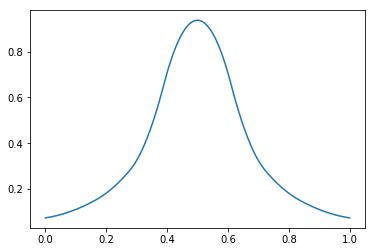

In [67]:
plot(x,B.dot(myfun(q)))

In [68]:
#2.Least squares: p = (B^T B)B^Tf (p is the polynomial, f is the function)

In [69]:
BtB = B.T.dot(B)
#BtBinv = linalg.inv(BtB) # do not do direct inverse like this!

pL2 = linalg.solve(BtB, B.T.dot(myfun(x))) # f is myfun here

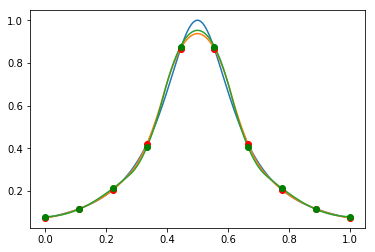

In [70]:
plot(x,myfun(x))
plot(x,B.dot(myfun(q)))
plot(x,B.dot(pL2))
plot(q,myfun(q),'ro')
plot(q,pL2,'go') #this green line soes not mathch with the function at some points, because it is not trying to interpolate the function

We want to solve $-u''+u = f$ on $[0,1]$, with $u'(0) =u'(1) = 0$ in the weak sense, so we multiply times a function: ${(-u'',v)}_{L^2} + {(u,v)}_{L^2} = {(f,v)}_{L^2}$, and integrating by parts inoder to minimize $\varepsilon(v) := \frac{1}{2}\left({||v||}_{L^2} + {||v'||}_{L^2} - (f,v)\right)$, we get ${(u',v)}_{L^2} + {(u,v)}_{L^2} = {(f,v)}_{L^2}$, $\forall v \in {\mathcal{H}}([a,b])$ 


Up to now, what we have evaluated is sth like ${(u,v)}_{L^2} = {(f,v)}_{L^2}$, without the parts with the derivatives.

We are now gonna solve sth slightly different, like: $(p^j {v_j}',{v_i}') + (p^j {v_j},{v_i}) = (f,v_i)$

In [71]:
A = dB.T.dot(dB) + B.T.dot(B)

In [72]:
#Let us try to solve the problem with a constant rhs (the constant we put equal to one)

rhs = B.T.dot(x*0 +1)
u = linalg.solve(A,rhs)

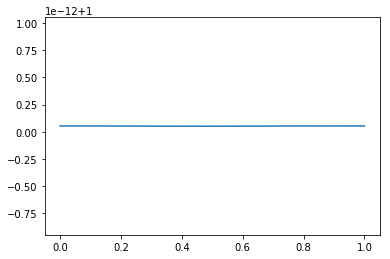

In [73]:
plot(x,B.dot(u)) # -u'' + u = 1 if u =1 (not really funny)

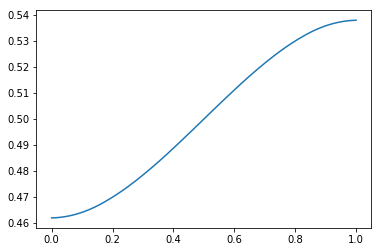

In [74]:
#We want to take a linear function now

rhs = B.T.dot(x)
u = linalg.solve(A,rhs)
plot(x,B.dot(u)) #looks like a sigmoid but is not a sigmoid really, because you need -u''+u = f to hold

In [76]:
dB.dot(u)[[0,-1]] #the derivative is not zero! You are making an approximation on the result with least squares

array([0.00272435, 0.00272435])

In [80]:
AA = zeros((M,M))

basis = []
dbasis = []

for i in range(M):
    c = zeros((M,))  #coefficients: you can also do c = q*0
    c[i] = 1
    basis.append(PPoly.from_spline(splrep(q,c, k = 2)))
    dbasis.append(basis[i].derivative(1))
                 

In [82]:
from scipy.integrate import *

qpoints,weights = numpy.polynomial.legendre.leggauss(3)

In [83]:
qpoints,weights

(array([-0.77459667,  0.        ,  0.77459667]),
 array([0.55555556, 0.88888889, 0.55555556]))

In [84]:
(qpoints**4).T.dot(weights)

0.40000000000000013